In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyedflib

import os
import sys
sys.path.append("..")

from sleeprnn.data import utils
from sleeprnn.common import viz, constants
from sleeprnn.helpers import reader

In [2]:
def get_spectrum(data, fs, f_min=0, f_max=40, window_fn=None):
    if window_fn is not None:
        window = window_fn(data.size)
        data = data * window
    y = np.fft.rfft(data)
    freq = np.fft.rfftfreq(data.size, d=1./fs)
    valid_locs = np.where((freq>=f_min) & (freq<=f_max))[0]
    freq = freq[valid_locs]
    y = y[valid_locs]
    return freq, y


def get_mean_spectrum(data, fs, f_min=0, f_max=40, window_fn=None):
    power_list = []
    for d in data:
        freq, y = get_spectrum(d, fs, f_min, f_max, window_fn)
        power_list.append(np.abs(y))
    power_mean = np.stack(power_list, axis=0).mean(axis=0)
    return freq, power_mean

In [3]:
PATH_REC = 'register'
PATH_MARKS = os.path.join('label', 'spindle')
PATH_STATES = os.path.join('label', 'state')
KEY_FILE_EEG = 'file_eeg'
KEY_FILE_STATES = 'file_states'
KEY_FILE_MARKS = 'file_marks'
IDS_INVALID = [4, 8, 15, 16]
IDS_TEST = [2, 6, 12, 13]


class MassRaw(object):
    def __init__(self):
        self.fs = 256
        self.page_duration = 20
        self.page_size = int(self.page_duration * self.fs)
        self.channel = 'EEG C3-CLE'
        self.state_ids = np.array(['1', '2', '3', '4', 'R', 'W', '?'])
        self.unknown_id = '?'  # Character for unknown state in hypnogram
        self.n2_id = '2'  # Character for N2 identification in hypnogram
        valid_ids = [i for i in range(1, 20) if i not in IDS_INVALID]
        self.test_ids = IDS_TEST
        self.train_ids = [i for i in valid_ids if i not in self.test_ids]
        self.dataset_dir = os.path.abspath(os.path.join(utils.PATH_DATA, 'mass'))
        self.all_ids = self.train_ids + self.test_ids
        self.dataset_name = "mass_raw"
        
    def _get_file_paths(self):
        """Returns a list of dicts containing paths to load the database."""
        # Build list of paths
        data_paths = {}
        for subject_id in self.all_ids:
            path_eeg_file = os.path.join(
                self.dataset_dir, PATH_REC,
                '01-02-%04d PSG.edf' % subject_id)
            path_states_file = os.path.join(
                self.dataset_dir, PATH_STATES,
                '01-02-%04d Base.edf' % subject_id)
            path_marks_1_file = os.path.join(
                self.dataset_dir, PATH_MARKS,
                '01-02-%04d SpindleE1.edf' % subject_id)
            path_marks_2_file = os.path.join(
                self.dataset_dir, PATH_MARKS,
                '01-02-%04d SpindleE2.edf' % subject_id)
            # Save paths
            ind_dict = {
                KEY_FILE_EEG: path_eeg_file,
                KEY_FILE_STATES: path_states_file,
                '%s_1' % KEY_FILE_MARKS: path_marks_1_file,
                '%s_2' % KEY_FILE_MARKS: path_marks_2_file
            }
            # Check paths
            for key in ind_dict:
                if not os.path.isfile(ind_dict[key]):
                    print(
                        'File not found: %s' % ind_dict[key])
            data_paths[subject_id] = ind_dict
        return data_paths
    
    def get_subject_data(self, subject_id):
        data_paths = self._get_file_paths()
        path_dict = data_paths[subject_id]
        signal = self._read_eeg(path_dict[KEY_FILE_EEG])
        hypnogram, start_sample = self._read_states_raw(path_dict[KEY_FILE_STATES])
        signal, hypnogram, end_sample = self._fix_signal_and_states(signal, hypnogram, start_sample)
        return signal, hypnogram
    
    def _read_eeg(self, path_eeg_file):
        """Loads signal from 'path_eeg_file', does filtering and resampling."""
        with pyedflib.EdfReader(path_eeg_file) as file:
            channel_names = file.getSignalLabels()
            channel_to_extract = channel_names.index(self.channel)
            signal = file.readSignal(channel_to_extract)
            fs_old = file.samplefrequency(channel_to_extract)
        # Particular fix for mass dataset:
        fs_old_round = int(np.round(fs_old))
        # Transform the original fs frequency with decimals to rounded version
        signal = utils.resample_signal_linear(signal, fs_old=fs_old, fs_new=fs_old_round)
        signal = signal.astype(np.float32)
        return signal
    
    def _read_states_raw(self, path_states_file):
        """Loads hypnogram from 'path_states_file'."""
        with pyedflib.EdfReader(path_states_file) as file:
            annotations = file.readAnnotations()
        onsets = np.array(annotations[0])  # In seconds
        durations = np.round(np.array(annotations[1]))  # In seconds
        stages_str = annotations[2]
        # keep only 20s durations
        valid_idx = (durations == self.page_duration)
        onsets = onsets[valid_idx]
        stages_str = stages_str[valid_idx]
        stages_char = np.asarray([single_annot[-1] for single_annot in stages_str])
        # Sort by onset
        sorted_locs = np.argsort(onsets)
        onsets = onsets[sorted_locs]
        stages_char = stages_char[sorted_locs]
        # The hypnogram could start at a sample different from 0
        start_time = onsets[0]
        onsets_relative = onsets - start_time
        onsets_pages = np.round(onsets_relative / self.page_duration).astype(np.int32)
        n_scored_pages = 1 + onsets_pages[-1]  # might be greater than onsets_pages.size if some labels are missing
        start_sample = int(start_time * self.fs)
        hypnogram = (n_scored_pages + 1) * [self.unknown_id]  # if missing, it will be "?", we add one final '?'
        for scored_pos, scored_label in zip(onsets_pages, stages_char):
            hypnogram[scored_pos] = scored_label
        hypnogram = np.asarray(hypnogram)
        return hypnogram, start_sample

    def _fix_signal_and_states(self, signal, hypnogram, start_sample):
        # Crop start of signal
        signal = signal[start_sample:]
        # Find the largest valid sample, common in both signal and hypnogram, with an integer number of pages
        n_samples_from_signal = int(self.page_size * (signal.size // self.page_size))
        n_samples_from_hypnogram = int(hypnogram.size * self.page_size)
        n_samples_valid = min(n_samples_from_signal, n_samples_from_hypnogram)
        n_pages_valid = int(n_samples_valid / self.page_size)
        # Fix signal and hypnogram according to this maximum sample
        signal = signal[:n_samples_valid]
        hypnogram = hypnogram[:n_pages_valid]
        end_sample = start_sample + n_samples_valid  # wrt original beginning of recording, useful for marks
        return signal, hypnogram, end_sample

# MASS-SS2-Train mean spectrum

In [4]:
mass = MassRaw()
fs = mass.fs
# Stages: ['1' '2' '3' '4' '?' 'R' 'W']

In [23]:
stages_for_spectrum = ['2']
powers = []
freq_axis = []
for subject_id in mass.train_ids:
    signal, hypnogram = mass.get_subject_data(subject_id)
    valid_locs = np.isin(hypnogram, stages_for_spectrum)
    signal = signal.reshape(-1, mass.page_size)
    signal = signal[valid_locs, :]
    freq, power_mean = get_mean_spectrum(signal, fs, f_min=1, f_max=35, window_fn=np.hanning)
    powers.append(power_mean)
    freq_axis.append(freq)
freq_axis = np.stack(freq_axis, axis=0).mean(axis=0)
powers = np.stack(powers, axis=0)
powers_n2 = powers

In [24]:
stages_for_spectrum = ['1', '2', '3', '4']
powers = []
freq_axis = []
for subject_id in mass.train_ids:
    signal, hypnogram = mass.get_subject_data(subject_id)
    valid_locs = np.isin(hypnogram, stages_for_spectrum)
    signal = signal.reshape(-1, mass.page_size)
    signal = signal[valid_locs, :]
    freq, power_mean = get_mean_spectrum(signal, fs, f_min=1, f_max=35, window_fn=np.hanning)
    powers.append(power_mean)
    freq_axis.append(freq)
freq_axis = np.stack(freq_axis, axis=0).mean(axis=0)
powers = np.stack(powers, axis=0)
powers_nrem = powers

In [25]:
def fit_power_law(f, p, f_min=0.1, f_max=40):
    # p = af^b -> log(p) = log(a) + b*log(f)
    valid_locs = np.where((f>=f_min) & (f<=f_max))[0]
    log_p = np.log(p[valid_locs])
    log_f = np.log(f[valid_locs])
    polycoefs = np.polynomial.Polynomial.fit(log_f, log_p, deg=1).convert().coef
    scale = polycoefs[0]
    exponent = polycoefs[1]
    return exponent, scale

def find_offset(freq_axis, power, offset_grid, f_min=0.1, f_max=40):
    error_list = []
    for offset in offset_grid:
        exponent, scale = fit_power_law(freq_axis + offset, power, f_min, f_max)
        power_fit = np.exp(scale) * ((freq_axis + offset) ** exponent)
        error = np.abs((power_fit - power)**2).mean()
        error_list.append(error)
    best = np.argmin(error_list)
    return offset_grid[best]

def find_offset_power_law(freq_axis, power, f_min=0.1, f_max=40, fit_offset=False):
    if fit_offset:
        offset_grid = np.linspace(0, 10, 2000)
        offset = find_offset(freq_axis, power, offset_grid, f_min, f_max)
    else:
        offset = 0
    exponent, scale = fit_power_law(freq_axis + offset, power, f_min, f_max)
    return scale, offset, exponent

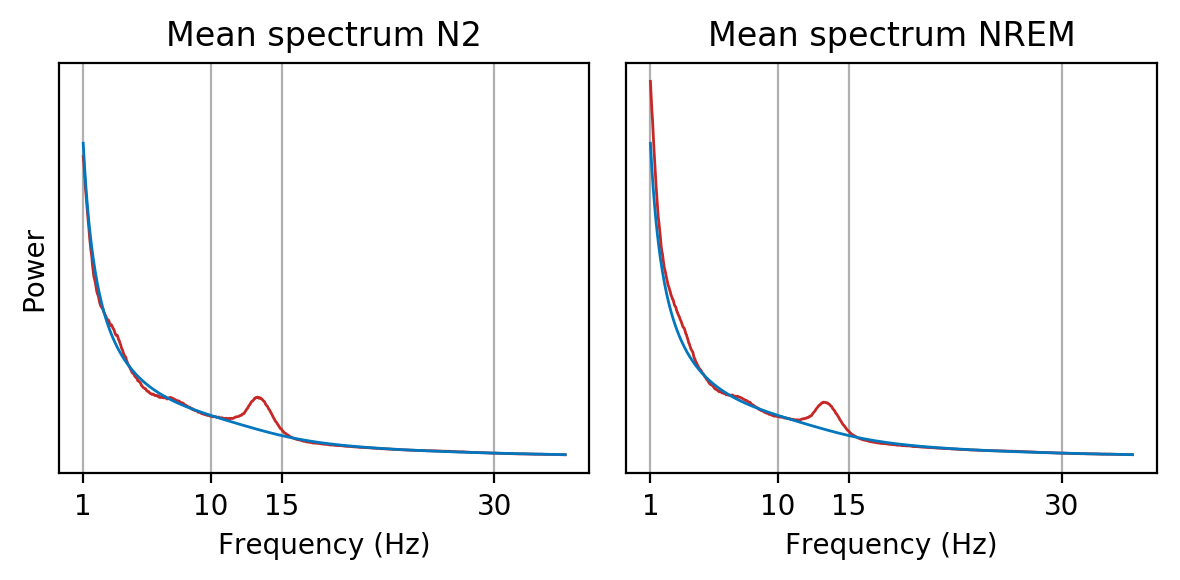

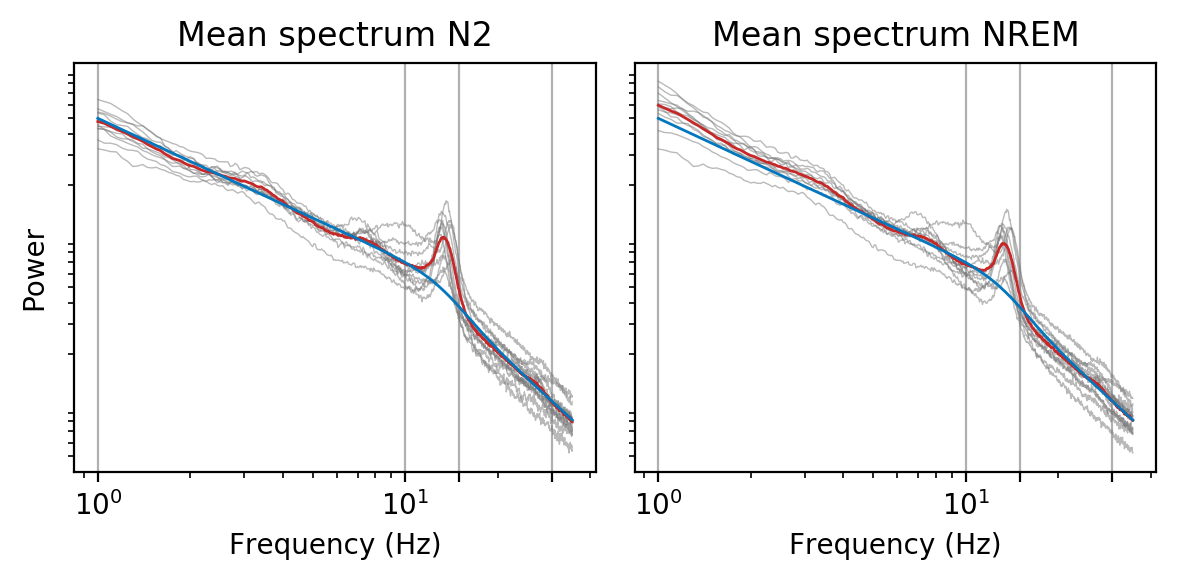

Power law fit
P = exp(A) * f ^ C with
C-1 = -0.842227
C-2 = -1.671911
A-2 / A-1 = 1.217506


In [34]:
# exponent_n2, scale_n2 = fit_power_law(freq_axis, powers_n2.mean(axis=0), f_min=1, f_max=15)
# exponent_nrem, scale_nrem = fit_power_law(freq_axis, powers_nrem.mean(axis=0), f_min=1, f_max=15)
mass_n2_mean = powers_n2.mean(axis=0)
scale_n2_1, offset_n2_1, exponent_n2_1 = find_offset_power_law(freq_axis, mass_n2_mean, f_min=0.1, f_max=10)
scale_n2_2, offset_n2_2, exponent_n2_2 = find_offset_power_law(freq_axis, mass_n2_mean, f_min=17, f_max=35)
freq_transition = 13
tau = 2
power_1 = np.exp(scale_n2_1) * ((freq_axis + offset_n2_1) ** exponent_n2_1)
power_2 = np.exp(scale_n2_2) * ((freq_axis + offset_n2_2) ** exponent_n2_2)
sigmoid = 1 / (1 + np.exp(-(freq_axis - freq_transition)/tau))
fitted_p = power_2 * sigmoid + power_1 * (1 - sigmoid)


# scale_nrem, offset_nrem, exponent_nrem = find_offset_power_law(freq_axis, powers_nrem.mean(axis=0))

scale = scale_n2
offset = offset_n2
exponent = exponent_n2

fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=200, sharex=True, sharey=True)
ax = axes[0]
ax.set_title("Mean spectrum N2")
# for p in powers_n2:
#     ax.plot(freq_axis, p, linewidth=0.5, color=viz.GREY_COLORS[6], alpha=0.5)
ax.plot(freq_axis, powers_n2.mean(axis=0), linewidth=1, color=viz.PALETTE['red'])
#fitted_p = np.exp(scale) * ((freq_axis + offset) ** exponent)
ax.plot(freq_axis, fitted_p, linewidth=1, color=viz.PALETTE['blue'])
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power")
ax.set_xticks([1, 10, 15, 30])
ax.grid()
ax.set_yticks([])
ax = axes[1]
ax.set_title("Mean spectrum NREM")
# for p in powers_nrem:
#     ax.plot(freq_axis, p, linewidth=0.5, color=viz.GREY_COLORS[6], alpha=0.5)
ax.plot(freq_axis, powers_nrem.mean(axis=0), linewidth=1, color=viz.PALETTE['red'])
#fitted_p = np.exp(scale) * ((freq_axis + offset) ** exponent)
ax.plot(freq_axis, fitted_p, linewidth=1, color=viz.PALETTE['blue'])
ax.set_xlabel("Frequency (Hz)")
ax.set_xticks([1, 10, 15, 30])
ax.grid()
ax.set_yticks([])
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=200, sharex=True, sharey=True)
ax = axes[0]
ax.set_title("Mean spectrum N2")
for p in powers_n2:
    ax.loglog(freq_axis, p, linewidth=0.5, color=viz.GREY_COLORS[6], alpha=0.5)
ax.loglog(freq_axis, powers_n2.mean(axis=0), linewidth=1, color=viz.PALETTE['red'])
#fitted_p = np.exp(scale) * ((freq_axis + offset) ** exponent)
ax.loglog(freq_axis, fitted_p, linewidth=1, color=viz.PALETTE['blue'])
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power")
ax.set_xticks([1, 10, 15, 30])
ax.grid()
ax.set_yticks([])
ax = axes[1]
ax.set_title("Mean spectrum NREM")
for p in powers_nrem:
    ax.loglog(freq_axis, p, linewidth=0.5, color=viz.GREY_COLORS[6], alpha=0.5)
ax.loglog(freq_axis, powers_nrem.mean(axis=0), linewidth=1, color=viz.PALETTE['red'])
#fitted_p = np.exp(scale) * ((freq_axis + offset) ** exponent)
ax.loglog(freq_axis, fitted_p, linewidth=1, color=viz.PALETTE['blue'])
ax.set_xlabel("Frequency (Hz)")
ax.set_xticks([1, 10, 15, 30])
ax.grid()
ax.set_yticks([])
plt.tight_layout()
plt.show()

print("Power law fit")
print("P = exp(A) * f ^ C with")
print("C-1 = %1.6f" % exponent_n2_1)
print("C-2 = %1.6f" % exponent_n2_2)
print("A-2 / A-1 = %1.6f" % (scale_n2_2 / scale_n2_1))

# PINK v2

In [ ]:
def generate_signal_old(
    n_seconds, fs, seed,
    offset=7.153153,#4.207207, 
    exponent=-2.344606,#-2.012350, 
    f_low_clip=1,
):
    n_samples = int(n_seconds * fs)
    x = np.random.RandomState(seed=seed).normal(size=n_samples)
    y = np.fft.rfft(x)
    freq_gen = np.fft.rfftfreq(x.size, d=1./fs)
    freq_for_scaling = np.clip(freq_gen, a_min=f_low_clip, a_max=None)
    scaling = (freq_for_scaling + offset) ** exponent
    y = y * scaling
    x = np.fft.irfft(y)
    x = x - x.mean()
    x = x / x.std()
    return x

In [35]:
def get_scaling_profile(
    f, 
    exponent_1=-0.842227,
    exponent_2=-1.671911,
    scale_2=1.217506,
    transition_f=13.5,
    transition_tau=2,
):
    power_1 = f ** exponent_1  # Valid 1-10 Hz
    power_2 = np.exp(scale_2) * (f ** exponent_2)  # Valid 17-35 Hz
    sigmoid = 1 / (1 + np.exp(-(f - transition_f)/transition_tau))
    profile = power_2 * sigmoid + power_1 * (1 - sigmoid)
    return profile


def generate_signal(
    n_seconds, fs, seed,
    f_low_clip=1,
):
    n_samples = int(n_seconds * fs)
    x = np.random.RandomState(seed=seed).normal(size=n_samples)
    y = np.fft.rfft(x)
    freq_gen = np.fft.rfftfreq(x.size, d=1./fs)
    freq_for_scaling = np.clip(freq_gen, a_min=f_low_clip, a_max=None)
    scaling = get_scaling_profile(freq_for_scaling)
    y = y * scaling
    x = np.fft.irfft(y)
    x = x - x.mean()
    x = x / x.std()
    return x

In [36]:
fs = 200
pink_seconds = 3600 * 3
pink_signal = generate_signal(pink_seconds, fs, 0)
pink_signal = utils.broad_filter(pink_signal, fs, lowcut=0.5)
pink_signal = pink_signal / pink_signal.std()
pink_signal = 16.7 * pink_signal
pink_signal = pink_signal.reshape(-1, 4000)

/home/ntapia/miniconda3/envs/tf/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [37]:
mass = reader.load_dataset(constants.MASS_SS_NAME, load_checkpoint=True, verbose=False)

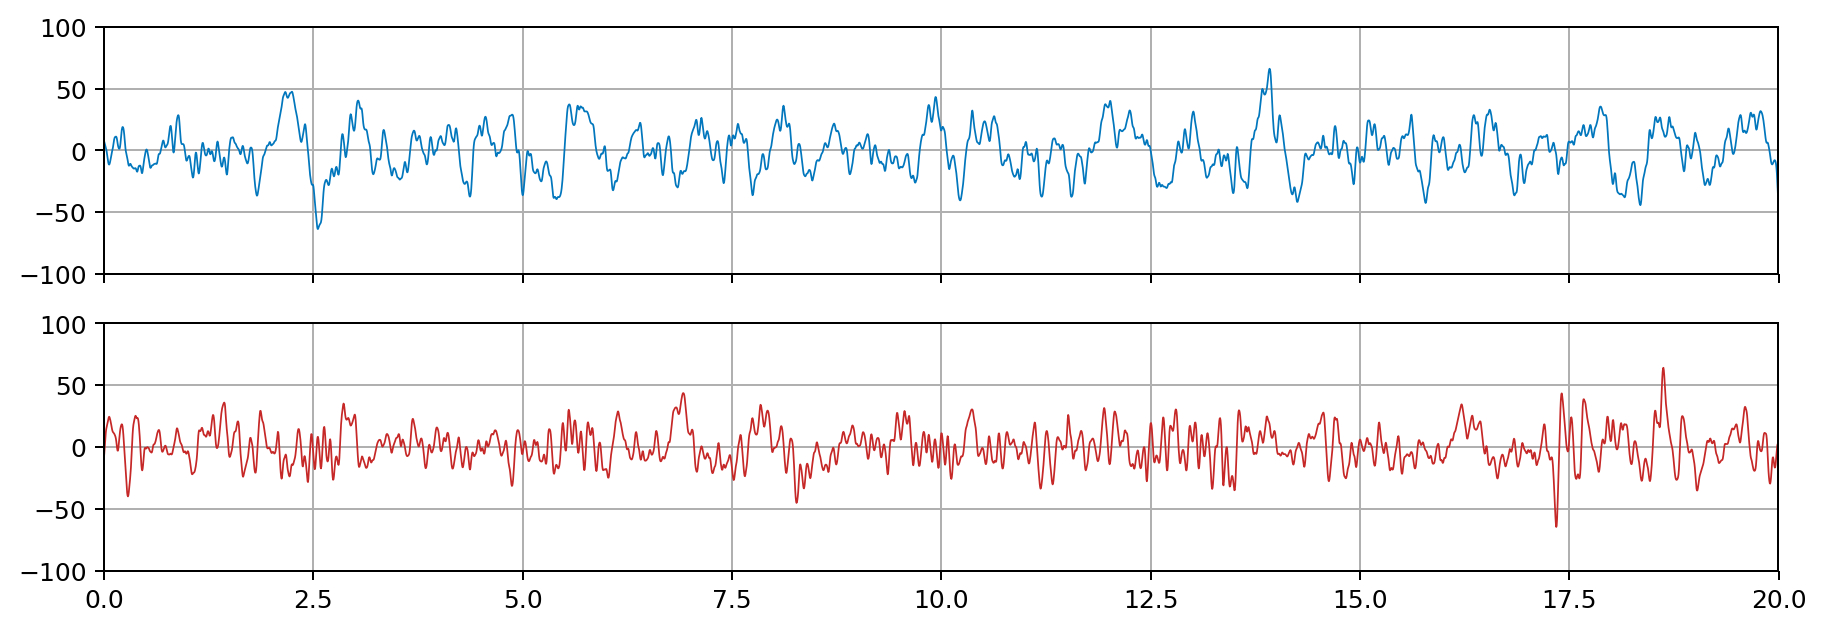

In [38]:
subject_id_mass = 1
mass_signal, _ = mass.get_subject_data(subject_id_mass, which_expert=1, normalize_clip=False)

which_pink = 10
which_mass = 10
fig, ax = plt.subplots(2, 1, figsize=(12, 4), dpi=180, sharex=True)
time_axis = np.arange(4000) / fs
ax[0].plot(time_axis, pink_signal[which_pink, :], linewidth=0.7, color=viz.PALETTE['blue'])
ax[1].plot(time_axis, mass_signal[which_mass, :], linewidth=0.7, color=viz.PALETTE['red'])
for s_ax in ax.flatten():
    s_ax.set_ylim([-100, 100])
    s_ax.set_xlim([time_axis[0], time_axis[-1]])
    s_ax.grid()
plt.show()

In [39]:
f_min = 0.1
f_max = 35
freq, power_mean_pink = get_mean_spectrum(pink_signal, fs, f_min=f_min, f_max=f_max, window_fn=np.hanning)

powers_mass = []
freq_mass = []
for subject_id in mass.train_ids:
    signal, _ = mass.get_subject_data(subject_id, which_expert=1, normalize_clip=False)
    freq, power_mean = get_mean_spectrum(signal, fs, f_min=f_min, f_max=f_max, window_fn=np.hanning)
    powers_mass.append(power_mean)
    freq_mass.append(freq)
freq_mass = np.stack(freq_mass, axis=0).mean(axis=0)
powers_mass = np.stack(powers_mass, axis=0)

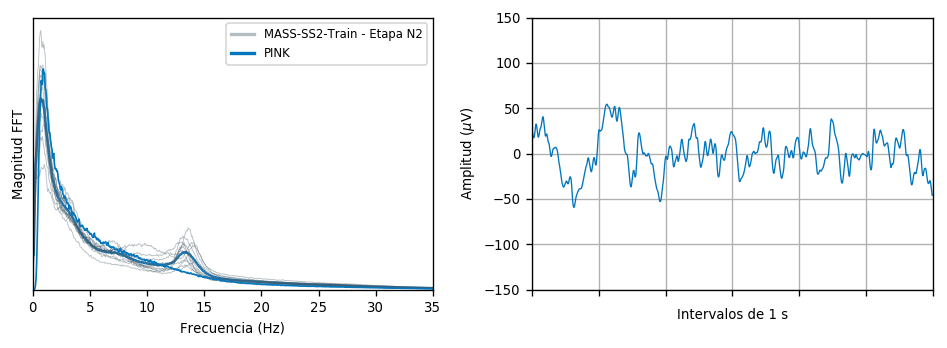

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=120)

ax = axes[0]
label = "MASS-SS2-Train - Etapa N2"
ax.plot(freq_mass, powers_mass.mean(axis=0))
for p in powers_mass:
    ax.plot(freq_mass, p, color=viz.PALETTE['grey'], linewidth=0.5, label=label, alpha=0.4)
    label = None
ax.plot(
    freq, power_mean_pink, color=viz.PALETTE['blue'], linewidth=1, 
    label="PINK")
ax.set_yticks([])
ax.tick_params(labelsize=8)
ax.set_xlabel("Frecuencia (Hz)", fontsize=8)
ax.set_ylabel("Magnitud FFT", fontsize=8)
leg = ax.legend(loc="upper right", fontsize=7)
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)
ax.set_ylim([0, None])
ax.set_xlim([0, 35])

ax = axes[1]
n_seconds_to_demo = 6
demo_signal = pink_signal[30, :(fs * n_seconds_to_demo)]
time_axis = np.arange(demo_signal.size) / fs
ax.plot(time_axis, demo_signal, linewidth=0.8, color=viz.PALETTE['blue'])
ax.set_ylim([-150, 150])
ax.set_xlim([time_axis[0], time_axis[-1]])
ax.set_xticks(np.arange(n_seconds_to_demo + 1))
ax.set_xticklabels([])
ax.tick_params(labelsize=8)
ax.set_xlabel("Intervalos de 1 s", fontsize=8)
ax.set_ylabel("Amplitud ($\mu$V)", fontsize=8)
ax.grid()

plt.tight_layout()
plt.show()